In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_orig=pd.read_csv('../input/lending-club/accepted_2007_to_2018Q4.csv.gz',low_memory=False)

In [3]:
df_orig.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


# Intial data analysis to look at the structure and understand the features

For training our pd model, we will only look at default and fully paid loans

In [4]:
df = df_orig[(df_orig['loan_status']=='Fully Paid') | (df_orig['loan_status']=='Charged Off')]
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
5,68426831,NaN,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


Changing the variable to binary classifier

In [5]:
df['loan_status_bin'] = df['loan_status'].map({'Charged Off': 1, 'Fully Paid': 0})

### Looking at feature grade

Looking at the number of cutomers accepted in each grade, we can see that the grades with high number of customers are 'B' and 'C'



<AxesSubplot:>

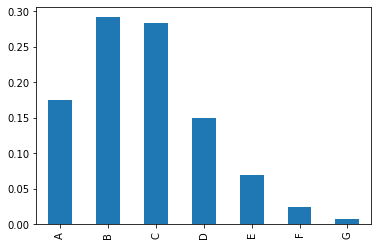

In [6]:
(df['grade'].value_counts().sort_index()/len(df)).plot.bar()

### Looking at feature employment length

Before we can have a look at the distribution of the employment length we need to transform it into numerical values

<AxesSubplot:>

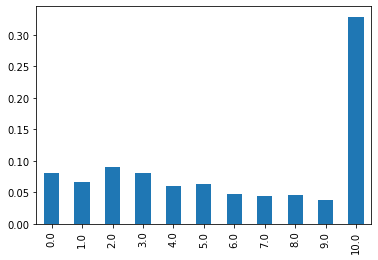

In [7]:
def emp_to_num(term):
    if pd.isna(term):
        return None
    elif term[2]=='+':
        return 10
    elif term[0]=='<':
        return 0
    else:
        return int(term[0])

df['emp_length_num'] = df['emp_length'].apply(emp_to_num)
(df['emp_length_num'].value_counts().sort_index()/len(df)).plot.bar()

<AxesSubplot:xlabel='emp_length_num'>

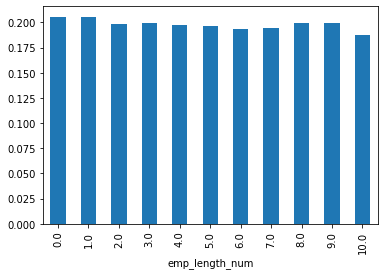

In [8]:
df.groupby('emp_length_num')['loan_status_bin'].mean().plot.bar()

Plotting the relation between employment length and default rate, we can see that there is no relation,i.e almost 2 to 9 have the same default rate, only <= 1 has a slightly higher and >10 has a slightly lower rate,so we will just divide the employment length into 2 variables 10+ and <=1 year

In [9]:
df['long_emp'] = df['emp_length'].apply(lambda x: 1*(x=='10+ years'))
df['short_emp'] = df['emp_length'].apply(lambda x: 1*(x=='1 year' or x=='< 1 year'))

### Let's have a look at the distribution of interest rate

<AxesSubplot:ylabel='Frequency'>

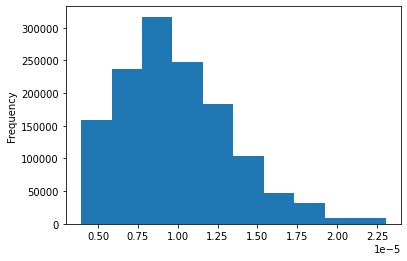

In [10]:
(df['int_rate']/len(df)).plot.hist(bins=10)

### Let's have a look at the distribution of annual income

This seems so be log-normal-distributed so we do a log-transform.

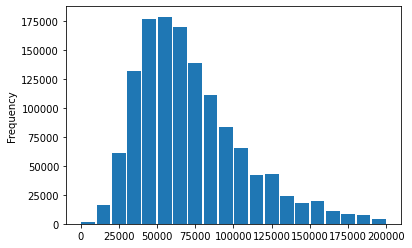

In [11]:
df[df['annual_inc']<200000]['annual_inc'].plot.hist(bins=20, rwidth=0.9)
df['annual_inc_log'] = df['annual_inc'].apply(np.log)

### Looking at feature purpose

We can see that the most frequent purpose is debt consolidation

<AxesSubplot:>

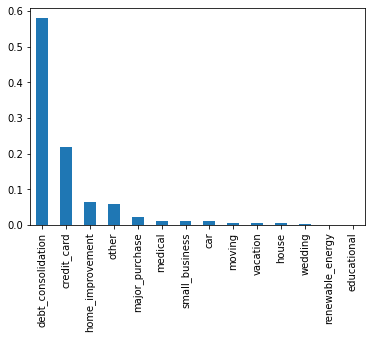

In [12]:
(df['purpose'].value_counts()/len(df)).plot.bar()

### Looking at the relationship between grade,default rate and interest rate

We can see almost a linear relation between default rate and grade

<AxesSubplot:xlabel='grade'>

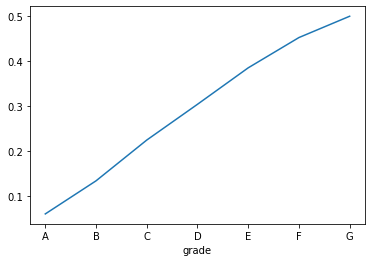

In [13]:
df.groupby('grade')['loan_status_bin'].mean().plot.line()

We can also see an almost linear relation between interest rate and grade

<AxesSubplot:xlabel='grade'>

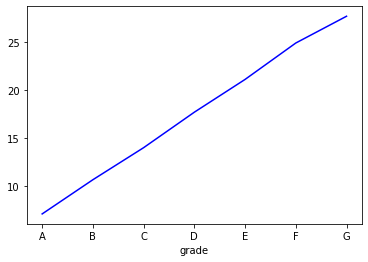

In [14]:
df.groupby('grade')['int_rate'].mean().plot.line(color='blue')

This means that there is also a linear relationship between interest rate and default rate which is an interesting observation, we will look into this later

### Looking at feature term

As we can see there are only two possible values for the term on Lending Club, i.e. 36 months or 60 months.

<AxesSubplot:title={'center':'value counts'}>

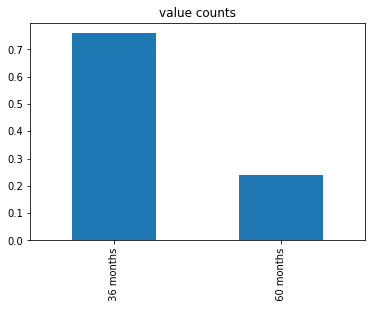

In [15]:
(df['term'].value_counts()/len(df)).plot.bar(title='value counts')

The accounts with a higher term have a significant higher default rate.

<AxesSubplot:title={'center':'default rate'}, xlabel='term'>

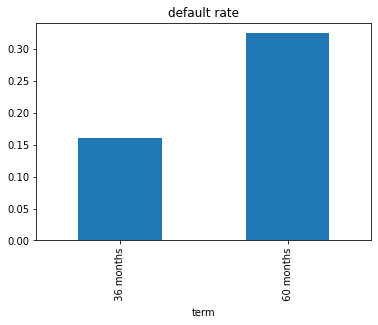

In [16]:
df.groupby('term')['loan_status_bin'].mean().plot.bar(title='default rate')

### Looking at feature homeownership

Doing the same with homeownership, the distribution among accounts is as follows

<AxesSubplot:title={'center':'value counts'}>

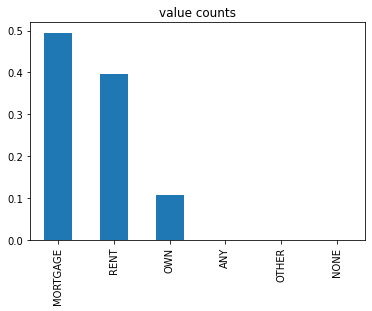

In [17]:
(df['home_ownership'].value_counts()/len(df)).plot.bar(title='value counts')

We can see that the default is higher in people who rent or own when compared to mortagage

<AxesSubplot:title={'center':'default rate'}, xlabel='home_ownership'>

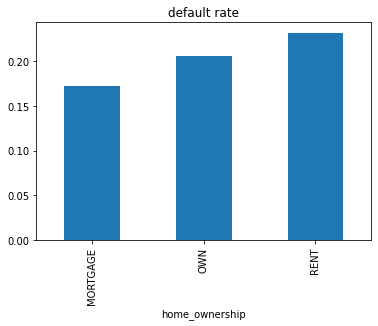

In [18]:
df[(df['home_ownership']=='MORTGAGE') | (df['home_ownership']=='OWN')| (df['home_ownership']=='RENT')].groupby('home_ownership')['loan_status_bin'].mean().plot.bar(title='default rate')

### Looking at feature FICO score

Taking a look at the fico score, we can see that most of out customers are in the FICO range 600-750

<AxesSubplot:title={'center':'FICO-Score'}, ylabel='Frequency'>

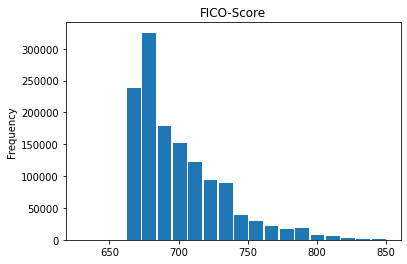

In [19]:
df['fico_range_high'].plot.hist(bins=20, title='FICO-Score', rwidth=0.9)

### Looking at feature installment

Also looking at the distribution for installment

<AxesSubplot:title={'center':'installment'}, ylabel='Frequency'>

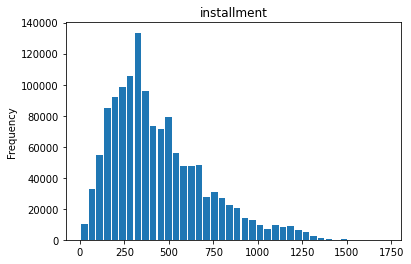

In [20]:
df['installment'].plot.hist(bins=40, title='installment', rwidth=0.85)

# Looking at the linear relationship between interest rates and default rates for a particular grade

As said before there seems to be a linear connection between the interest rate and the default rate. We will use Linear Regression to calculate the linear function that maps from the default rate to the interest rate.

In [21]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(df.groupby('sub_grade')['loan_status_bin'].mean().values.reshape(-1,1), y=df.groupby('sub_grade')['int_rate'].mean())

LinearRegression()

Text(0, 0.5, 'interest rate')

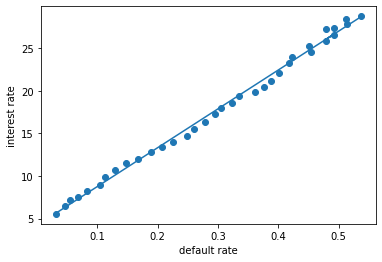

In [22]:
import matplotlib.pyplot as plt
plt.scatter(df.groupby('sub_grade')['loan_status_bin'].mean(), df.groupby('sub_grade')['int_rate'].mean())
plt.plot(df.groupby('sub_grade')['loan_status_bin'].mean(), lr.predict(df.groupby('sub_grade')['loan_status_bin'].mean().values.reshape(-1,1)))
plt.xlabel('default rate')
plt.ylabel('interest rate')

In [23]:
print('interest rate = ', lr.intercept_, '+', lr.coef_[0], '* default rate')

interest rate =  4.1683661690729 + 45.68477614996916 * default rate


From the above linear relation, we can see that when even in the same grade, if given a higher interest rate people are more likely to default when compared to a lower interest rate

# Traning the Logisitic Regression for PD model

Reduce the dataset to the following columns that are known to investors **before** the loan is funded.

In [24]:
columns = ['loan_amnt', 'term', 'int_rate',
       'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc_log', 'verification_status',
       'loan_status_bin', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs',
       'fico_range_low', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc']
df = df[columns]

Drop all rows that contain null-values.

In [25]:
df.dropna(inplace=True)

Transform the grade into numerical values.

In [26]:
df['grade']=df['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})

Get the dummy-variables for categorical features.

In [27]:
df_dummies = pd.get_dummies(df)

We are going to drop all dummy-variables which contain not at least 1% ones. In this case we can simply look at the mean of the features because all non-dummy variables have means greater than 0.01.



In [28]:
drop_columns = df_dummies.columns[(df_dummies.mean()<0.01)]
df_dummies.drop(drop_columns, axis=1, inplace=True)

Add the two different verification status variables that indicate verified to one variable.

In [29]:
df_dummies['verification_status_Verified_sum'] = df_dummies['verification_status_Source Verified']+df_dummies['verification_status_Verified']
df_dummies.drop(['verification_status_Source Verified', 'verification_status_Verified'], axis=1, inplace=True)

The transformed dataset looks like this

In [30]:
df_dummies.head()

,loan_amnt,int_rate,installment,grade,annual_inc_log,loan_status_bin,dti,delinq_2yrs,fico_range_low,inq_last_6mths,...,addr_state_OH,addr_state_OR,addr_state_PA,addr_state_SC,addr_state_TN,addr_state_TX,addr_state_VA,addr_state_WA,addr_state_WI,verification_status_Verified_sum
0,3600.0,13.99,123.03,3,10.915088,0,5.91,0.0,675.0,1.0,...,0,0,1,0,0,0,0,0,0,0
1,24700.0,11.99,820.28,3,11.082143,0,16.06,1.0,715.0,4.0,...,0,0,0,0,0,0,0,0,0,0
2,20000.0,10.78,432.66,2,11.050890,0,10.78,0.0,695.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,10400.0,22.45,289.91,6,11.556301,0,25.37,1.0,695.0,3.0,...,0,0,1,0,0,0,0,0,0,1
5,11950.0,13.44,405.18,3,10.434116,0,10.20,0.0,690.0,0.0,...,0,0,0,0,0,0,0,0,0,1


Seperate features from targets.

In [31]:
X = df_dummies.drop('loan_status_bin', axis=1)
y = df_dummies['loan_status_bin']

Split the data into training and testing data.

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Set up the pipeline. We will use L1 -penalty for built-in feature selection

In [33]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

sc = MinMaxScaler()
clf = LogisticRegression(penalty='l2', C=0.01)

pipe_lr = Pipeline([('scaler', sc), ('clf', clf)])

Train the logisitc regression model.

In [34]:
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('clf', LogisticRegression(C=0.01))])

# Evaluating the logistic regression model

**Here, to look at the accuracy of the model we are looking at ROC-AUC-score.**

ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. A score of 0.73 means that our is good at differentiating

ROC-AUC-score:  0.7104892429056107


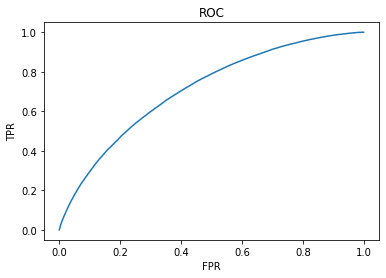

In [35]:
y_score = pipe_lr.predict_proba(X_test)[:,1]
from sklearn.metrics import roc_auc_score, roc_curve,precision_score, recall_score, precision_recall_curve
fpr, tpr, tresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')

print('ROC-AUC-score: ', roc_auc_score(y_test, y_score))

### Let's see which features are most important

In [36]:
for i in np.argsort(-np.abs(pipe_lr.named_steps['clf'].coef_[0])):
    print(X.columns[i], ': ', round(pipe_lr.named_steps['clf'].coef_[0,i], 4))

annual_inc_log :  -2.6783
open_acc :  1.8065
dti :  1.4653
fico_range_low :  -1.4382
grade :  1.1425
total_acc :  -1.0599
int_rate :  0.8063
installment :  0.5876
inq_last_6mths :  0.5253
addr_state_OR :  -0.3868
delinq_2yrs :  0.3778
purpose_small_business :  0.3567
revol_bal :  -0.3509
term_ 60 months :  0.3063
addr_state_CO :  -0.3047
term_ 36 months :  -0.301
addr_state_WA :  -0.2965
addr_state_LA :  0.2442
addr_state_SC :  -0.2258
addr_state_AL :  0.2096
pub_rec :  0.1996
home_ownership_MORTGAGE :  -0.1795
revol_util :  -0.1778
home_ownership_RENT :  0.1766
purpose_car :  -0.1696
addr_state_CT :  -0.1607
purpose_medical :  0.1492
addr_state_MO :  0.1313
addr_state_NV :  0.1182
addr_state_IN :  0.1085
addr_state_IL :  -0.1032
addr_state_TN :  0.0988
purpose_credit_card :  -0.0904
addr_state_GA :  -0.089
addr_state_NY :  0.0858
addr_state_MD :  0.0851
addr_state_FL :  0.0794
addr_state_NJ :  0.0787
addr_state_WI :  -0.0758
verification_status_Verified_sum :  0.0699
loan_amnt :  0.06

One can control the risk of the investments by choosing different tresholds. The higher one chooses the probability where to seperate good from bad loans the higher the default rate will be. We now write a function that transforms default probabilities to predictions. 

**<center>y_pred=1 if P(y_pred=1)≥θ else y_pred=0<center>**

**By applying varying classification thresholds, we can trace out explicitly the trade-off between preicision and recall from the PR curve.**

In [37]:
def plot_precision_recall_curve(y_score, y_test, thresholds):
    preds = [np.where(y_score > threshold, 1, 0) for threshold in thresholds]
    precisions = [precision_score(y_test, pred) for pred in preds]
    recalls = [recall_score(y_test, pred) for pred in preds]
    precision_recall = pd.DataFrame({'Precision': precisions, 'Recall': recalls, "Threshold": thresholds})
    

    precision_recall.plot(x = 'Threshold')
    plt.title('Precision, Recall vs. Threshold')
    plt.show()

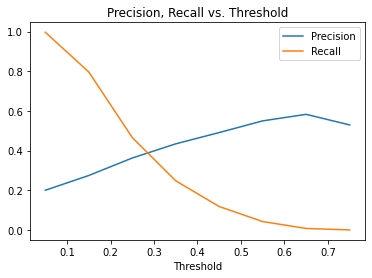

In [38]:
thresholds = np.arange(0.05, 0.85, 0.1)
plot_precision_recall_curve(y_score, y_test, thresholds)

* Positive: Charge Off
* Negative: Fully Paid
* Precision is defined as True Positive/(True Positive + False Positive).
* Recall is defined as True Positive/(True Positive + False Negative).
At the default threshold 0.2, we have a precision 0.3 and recall 0.65, which means we have a significant number of false positives. In other words, many borrowers who paid off are predicted to have a charge off.

In the business setting, the threshold is set differently by business objectives. For example, if LendingClub wants to minimize the loan loss due to charge offs, they may want to lower the threshold to get a good recall score. This would reduce the likelihood that the positive class(charge off) is missed. However, on the other side, the precision score would go down, resulting in more false positives. That means a growing number of borrowers who paid off are predicted to have a charge off. This would cause the borrowers to have a bad experience with the company. And more importantly, LendingClub would lose the interest income collected from those who are incorrectly classified. Vice versa.

# Loan Loss Prediction

By utilizing the machine learning model, we are trying to predict the loan loss for those current borrowers.

Assume threshold = 0.5.

In [39]:
business_data_orig=df_orig[df_orig['loan_status'] == 'Current']
business_data = df_orig[df_orig['loan_status'] == 'Current']
business_data['emp_length_num'] = business_data['emp_length'].apply(emp_to_num)
business_data['long_emp'] = business_data['emp_length'].apply(lambda x: 1*(x=='10+ years'))
business_data['short_emp'] = business_data['emp_length'].apply(lambda x: 1*(x=='1 year' or x=='< 1 year'))
# print(business_data.shape[0])
business_data = business_data[business_data['annual_inc']>0]
# print(business_data.shape[0])
business_data['annual_inc_log'] = business_data['annual_inc'].apply(np.log)
columns = ['loan_amnt', 'term', 'int_rate',
       'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc_log', 'verification_status','purpose',
       'addr_state', 'dti', 'delinq_2yrs',
       'fico_range_low', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc','funded_amnt']
business_data = business_data[columns]
business_data.dropna(inplace=True)
business_data['grade']=business_data['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})
business_data_dummies = pd.get_dummies(business_data)
drop_columns = business_data_dummies.columns[(business_data_dummies.mean()<0.01)]
business_data_dummies.drop(drop_columns, axis=1, inplace=True)
business_data_dummies['annual_inc_log'] = business_data['annual_inc_log']
business_data_dummies['verification_status_Verified_sum'] = business_data_dummies['verification_status_Source Verified']+business_data_dummies['verification_status_Verified']
business_data_dummies.drop(['verification_status_Source Verified', 'verification_status_Verified'], axis=1, inplace=True)
business_data_dummies.drop(['funded_amnt'],axis=1, inplace=True)
# print(len(business_data_dummies.columns))
# business_data_dummies['annual_inc_log'].min()

First we run the model with business data, and get the probability of charge off for each borrower.

In [40]:
y_score_business_data = pipe_lr.predict_proba(business_data_dummies)[:, 1]

Secondly we are going to use ECL model to calculate the expected loan loss.

Expected Credit Loss = LGD x PD x EAD The expected loss is calculated as a loan’s LGD multiplied by both its probability of default (PD) and the financial institution’s exposure at default (EAD).

LGD(%): the amount unrecovered by the lender after selling the underlying asset if a borrower defaults on a loan. Because there is no collateral requirement for all of loans in the data, LGD equals to 1.

PD: Probability of default, which is the feauture y_score_business_data.

EAD: Remaining outstanding principal, which is the feature 'funded_amnt'.

In [41]:
PD = pd.DataFrame(y_score_business_data.reshape(-1, 1))
EAD = pd.DataFrame(business_data['funded_amnt'])

Expected_Loss = PD.values * EAD.values
Expected_Loss

array([[6105.8789704 ],
       [3414.65882545],
       [2969.16858017],
       ...,
       [4139.54850999],
       [5999.92731078],
       [3719.48967146]])

In [42]:
business_data['expected_loss'] = Expected_Loss

In [43]:
print('We have {} current borrowers totally.'.format(business_data.shape[0]))

We have 811979 current borrowers totally.


### Distribution of Expected Loss

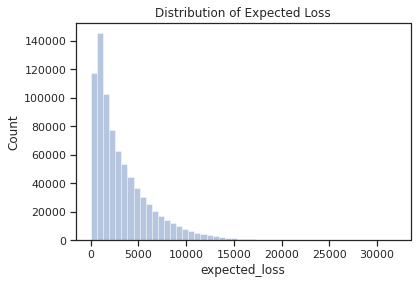

In [44]:
import seaborn as sns
sns.set(style = 'ticks')
sns.distplot(business_data['expected_loss'], kde = False)
# plt.xlim(0, 20000)
plt.title('Distribution of Expected Loss')
plt.ylabel("Count")
plt.show()

In [45]:
business_data['expected_loss'].describe()

count    811979.000000
mean       3281.832495
std        3120.801997
min          22.318613
25%        1011.490179
50%        2250.081717
75%        4570.273056
max       31915.581969
Name: expected_loss, dtype: float64

The mean expected loss is 3282. Over 30% of current borrowers owe less than 2500, while 75% of the population owe less than 5000. But we could also see some substantial loss, says 19000 or beyond.

### Grade vs. loan loss

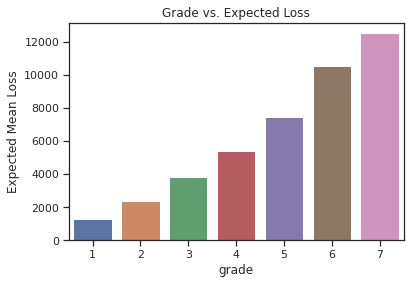

In [46]:
loss_by_grade = business_data[['grade', 'expected_loss']].groupby('grade').mean() \
                                                  .sort_values('expected_loss', ascending = False).head(10)

sns.barplot(loss_by_grade.index, loss_by_grade['expected_loss'])
plt.title('Grade vs. Expected Loss')
plt.ylabel("Expected Mean Loss")
plt.show()

The higher the grade, the less the mean loss. We would suggest enhancing scrutiny for borrowers with low grades since they are more likely to have charge offs with the greater amount.

### Term vs. loan loss

<AxesSubplot:title={'center':'term = 60 months'}, ylabel='Frequency'>

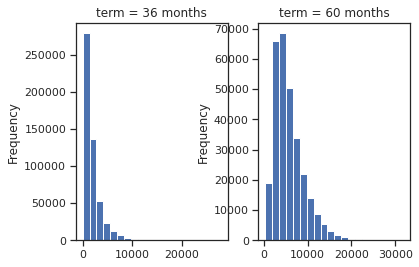

In [47]:
plt.subplot(1,2,1)
business_data[business_data['term']==' 36 months']['expected_loss'].plot.hist(bins=20,title='term = 36 months')
plt.subplot(1,2,2)
business_data[business_data['term']== ' 60 months']['expected_loss'].plot.hist(bins=20,title='term = 60 months')

We could see that most of our current payments are in the 60 month term, and we could also see that most of them are less than 10000 and in 36 months, since the number of loans are low the distribution is deverse

### Loan Loss by State

In [48]:
ls_state = business_data[['addr_state', 'expected_loss']].groupby('addr_state', as_index = False).sum() \
                                                  .sort_values('expected_loss', ascending = False)
ls_state.columns = ['State', 'Expected Loss']

<AxesSubplot:title={'center':'Expected Loss'}, xlabel='State'>

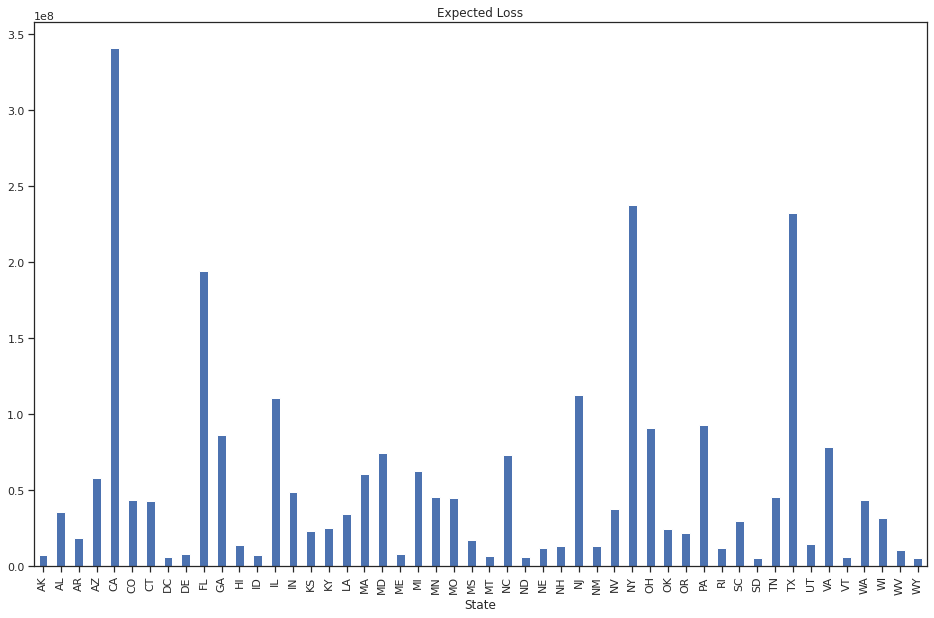

In [49]:
ls_state.groupby('State')['Expected Loss'].mean().plot.bar(title='Expected Loss',figsize=(16, 10))

California, New York, and Texas are the top three states with the highest expected loss. We would suggest making significant efforts to collect outstanding payments in these state. Also, stronger scrutiny on requests from these states